<a href="https://colab.research.google.com/github/ada-my619/Rock-Classification/blob/main/Rock_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock Fabric Classification

## Import the data

In [100]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tanyadayanand/geological-image-similarity")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'geological-image-similarity' dataset.
Path to dataset files: /kaggle/input/geological-image-similarity


In [92]:
import os

os.listdir(path)

['geological_similarity']

In [93]:
count = 0
limit = 2
for folder in os.listdir(path):
    print(f"\n📁 {folder}")
    # print(os.listdir(os.path.join(path, folder)))
    for subfolder in os.listdir(os.path.join(path, folder)):
        print(f"  📁 {subfolder}")
        # print(os.listdir(os.path.join(path, folder, subfolder)))
        count = 0
        for file in os.listdir(os.path.join(path, folder, subfolder)):
            if count < limit:
              print(f"    📄 {file}")
            else:
              print("     ....")
              break
            count += 1



📁 geological_similarity
  📁 quartzite
    📄 N2LU6.jpg
    📄 BUPNC.jpg
     ....
  📁 gneiss
    📄 I3KSJ.jpg
    📄 SJEMY.jpg
     ....
  📁 rhyolite
    📄 FC4QB.jpg
    📄 1QLVM.jpg
     ....
  📁 schist
    📄 SN0YG.jpg
    📄 OUP9W.jpg
     ....
  📁 marble
    📄 F4N0B.jpg
    📄 G7IT2.jpg
     ....
  📁 andesite
    📄 10DY6.jpg
    📄 5U01A.jpg
     ....


Dataset ImageFolder
    Number of datapoints: 29998
    Root location: /kaggle/input/geological-image-similarity/geological_similarity
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 

{'andesite': 0, 'gneiss': 1, 'marble': 2, 'quartzite': 3, 'rhyolite': 4, 'schist': 5}
torch.Size([3, 28, 28])
0


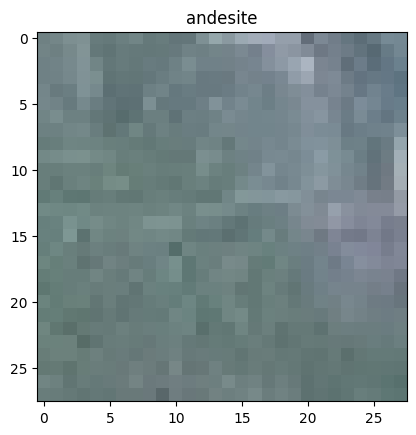

In [56]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

transform = transforms.Compose([
        transforms.ToTensor(),
    ])

rock_dataset = ImageFolder(root=os.path.join(path, "geological_similarity"), transform=transform)

print(rock_dataset, "\n")
print(rock_dataset.class_to_idx)

rock, target = rock_dataset[0]
print(rock.shape)
print(target)
plt.imshow(rock.permute(1, 2, 0))
plt.title(list(rock_dataset.class_to_idx)[target])
plt.show()

In [63]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np

def split_dataset(dataset, train_size=0.7, val_size=0.2, test_size=0.1, seed=42):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6 # "train, val, and test sizes must sum to 1"

    targets = [label for _, label in dataset.samples]
    indices = np.arange(len(targets))

    train_idx, temp_idx = train_test_split(
        indices,
        test_size=(1.0 - train_size),
        stratify=targets,
        random_state=seed
    )

    # split temp into val and test
    temp_targets = [targets[i] for i in temp_idx]
    val_ratio = val_size / (val_size + test_size)

    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=(1.0 - val_ratio),
        stratify=temp_targets,
        random_state=seed
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset   = Subset(dataset, val_idx)
    test_dataset  = Subset(dataset, test_idx)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(rock_dataset)
print(len(train_dataset), len(val_dataset), len(test_dataset))

20998 5999 3001


In [58]:
idx_to_class = {v: k for k, v in rock_dataset.class_to_idx.items()}
from collections import Counter

def print_class_proportion(dataset, name):
    labels = [dataset[i][1] for i in range(len(dataset))]
    counts = Counter(labels)
    total = len(labels)

    print(f"\n{name} (total = {total})")
    for label, count in sorted(counts.items()):
        class_name = idx_to_class[label]
        print(f"  {class_name:<10}: {count:>4} ({count/total:.2%})")
print_class_proportion(rock_dataset, "Full dataset")
print_class_proportion(train_dataset, "Train dataset")
print_class_proportion(val_dataset, "Validation dataset")
print_class_proportion(test_dataset, "Validation dataset")



Full dataset (total = 29998)
  andesite  : 5000 (16.67%)
  gneiss    : 5000 (16.67%)
  marble    : 4998 (16.66%)
  quartzite : 5000 (16.67%)
  rhyolite  : 5000 (16.67%)
  schist    : 5000 (16.67%)

Train dataset (total = 23998)
  andesite  : 4000 (16.67%)
  gneiss    : 4000 (16.67%)
  marble    : 3998 (16.66%)
  quartzite : 4000 (16.67%)
  rhyolite  : 4000 (16.67%)
  schist    : 4000 (16.67%)

Validation dataset (total = 4499)
  andesite  :  750 (16.67%)
  gneiss    :  750 (16.67%)
  marble    :  750 (16.67%)
  quartzite :  749 (16.65%)
  rhyolite  :  750 (16.67%)
  schist    :  750 (16.67%)

Validation dataset (total = 1501)
  andesite  :  250 (16.66%)
  gneiss    :  250 (16.66%)
  marble    :  250 (16.66%)
  quartzite :  251 (16.72%)
  rhyolite  :  250 (16.66%)
  schist    :  250 (16.66%)


In [59]:
batch_size = 32

In [101]:
from torch.utils.data import DataLoader
import torch

loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)
n_pixels = 0

for images, _ in loader:
    # images shape: (B, C, H, W)
    b, c, h, w = images.shape
    pixels = b * h * w
    n_pixels += pixels

    mean += images.sum(dim=[0, 2, 3])
    std  += (images ** 2).sum(dim=[0, 2, 3])

mean /= n_pixels
std = torch.sqrt(std / n_pixels - mean ** 2)

print(mean, std)

tensor([0.5081, 0.5197, 0.5193]) tensor([0.1860, 0.1984, 0.2188])


In [102]:
from numpy import random
import matplotlib.pyplot as plt

def get_classes(dataset):
    if hasattr(dataset, "classes"):
        return dataset.classes
    elif hasattr(dataset, "dataset") and hasattr(dataset.dataset, "classes"):
        return dataset.dataset.classes
    else:
        raise AttributeError("Dataset has no classes attribute")


def show_batch(dataset, nr=4, nc=4):
    classes = get_classes(dataset)

    fig, axarr = plt.subplots(nr, nc, figsize=(5, 5))
    for i in range(nr):
        for j in range(nc):
            idx = random.randint(0, len(dataset))
            sample, target = dataset[idx]

            # normalize for display if needed
            if sample.min() < 0.:
                sample = (sample - sample.min()) / (sample.max() - sample.min())

            # show image
            if sample.ndim == 3:
                axarr[i][j].imshow(sample.permute(1, 2, 0))
            else:
                axarr[i][j].imshow(sample)

            target_name = classes[target]
            axarr[i][j].set_title(f"{target_name} ({target})")
            axarr[i][j].axis("off")

    fig.tight_layout(pad=1.5)
    plt.show()


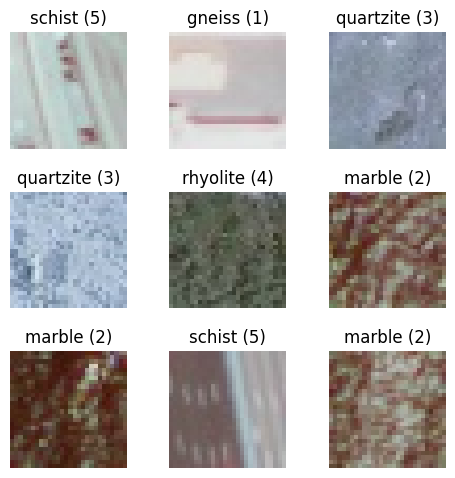

In [66]:
show_batch(train_dataset, 3, 3)

In [103]:
# Finally add normalisation to transforms
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

rock_dataset = ImageFolder(root=os.path.join(path, "geological_similarity"), transform=transform)

train_dataset, val_dataset, test_dataset = split_dataset(rock_dataset)
print(len(train_dataset), len(val_dataset), len(test_dataset))

20998 5999 3001


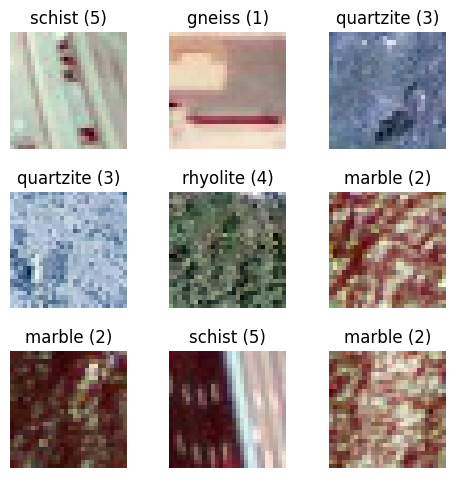

In [104]:
show_batch(train_dataset, 3, 3)

In [105]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [78]:
!pip install pycm livelossplot
%pylab inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np
import random

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['mean', 'std', 'grid', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [79]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [80]:
set_seed(42)

True

In [107]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # print(X.shape)
        a2 = model(X.view(-1, 3, 28, 28))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss.item()*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    with torch.no_grad():
      for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 28, 28))
            loss = criterion(a2, y)
            validation_loss += loss.item()*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 28, 28))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

## Baseline CNN

In [108]:
class SmallCNN(nn.Module):
    def __init__(self, in_channels=3, out=6):
        super().__init__()

        # Conv layer
        self.features = nn.Sequential(
            # Block 1: 28x28 -> 28x28
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Block 2: 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 3: 14x14 -> 7x7
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        # Class layer
        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, out)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.embedding(x)
        return x


In [117]:
lr = 1e-5
n_epochs = 20
wd = 1e-4

In [118]:
small_cnn = SmallCNN().to(device)
summary(small_cnn, input_size=(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
       BatchNorm2d-9          [-1, 128, 14, 14]             256
             ReLU-10          [-1, 128, 14, 14]               0
        MaxPool2d-11            [-1, 128, 7, 7]               0
          Flatten-12                 [-1, 6272]               0
           Linear-13                    [-1, 6]          37,638
Total params: 131,334
Trainable params:

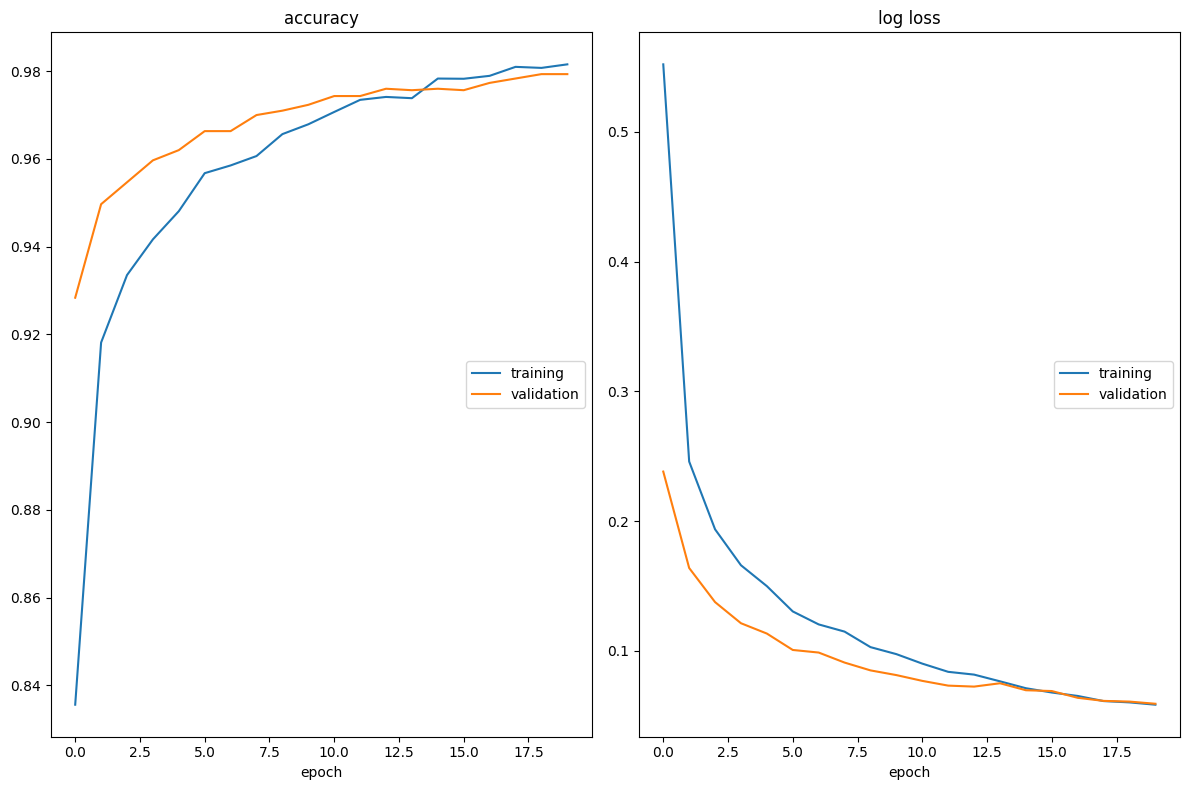

accuracy
	training         	 (min:    0.836, max:    0.982, cur:    0.982)
	validation       	 (min:    0.928, max:    0.979, cur:    0.979)
log loss
	training         	 (min:    0.058, max:    0.552, cur:    0.058)
	validation       	 (min:    0.059, max:    0.238, cur:    0.059)
Avg. Test Loss: 0.059  Avg. Test Accuracy: 0.979



In [119]:
optimizer = torch.optim.Adam(small_cnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(small_cnn, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss
    logs['' + 'accuracy'] = train_accuracy

    validation_loss, validation_accuracy = validate(small_cnn, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss
    logs['val_' + 'accuracy'] = validation_accuracy

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(small_cnn, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss, " Avg. Test Accuracy: %1.3f" % test_accuracy)
print("")

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       500
           1       0.98      0.98      0.98       500
           2       1.00      1.00      1.00       500
           3       0.97      0.98      0.98       501
           4       0.97      0.99      0.98       500
           5       0.98      0.98      0.98       500

    accuracy                           0.98      3001
   macro avg       0.98      0.98      0.98      3001
weighted avg       0.98      0.98      0.98      3001



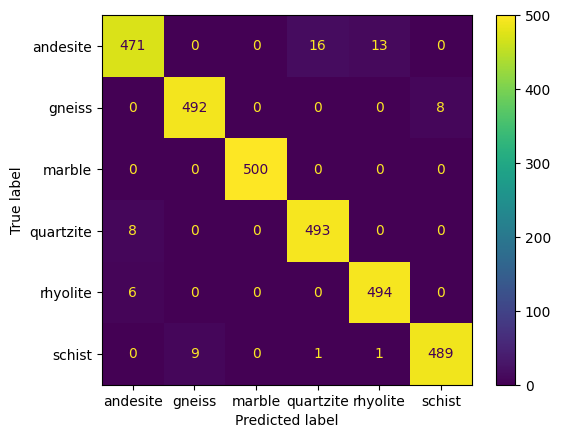

In [394]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# create the confusion matrix for prediction
y_pred, y_true = evaluate(small_cnn, test_loader)

cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
print(classification_report(y_true, y_pred))
# make the label 0, 1, 2,... to folder name
cm.ax_.set_xticklabels(list(rock_dataset.class_to_idx))
cm.ax_.set_yticklabels(list(rock_dataset.class_to_idx))
plt.show()
print(cm)

[  43   51   83  107  126  182  214  338  387  416  494  496  537  557
  649  693  721  889  901 1050 1061 1120 1172 1175 1190 1262 1271 1340
 1366 1454 1468 1496 1504 1589 1593 1614 1622 1688 1690 1730 1742 1777
 1860 1884 2014 2031 2106 2113 2221 2367 2378 2463 2530 2571 2602 2639
 2785 2852 2906 2956 2958 2970]
62


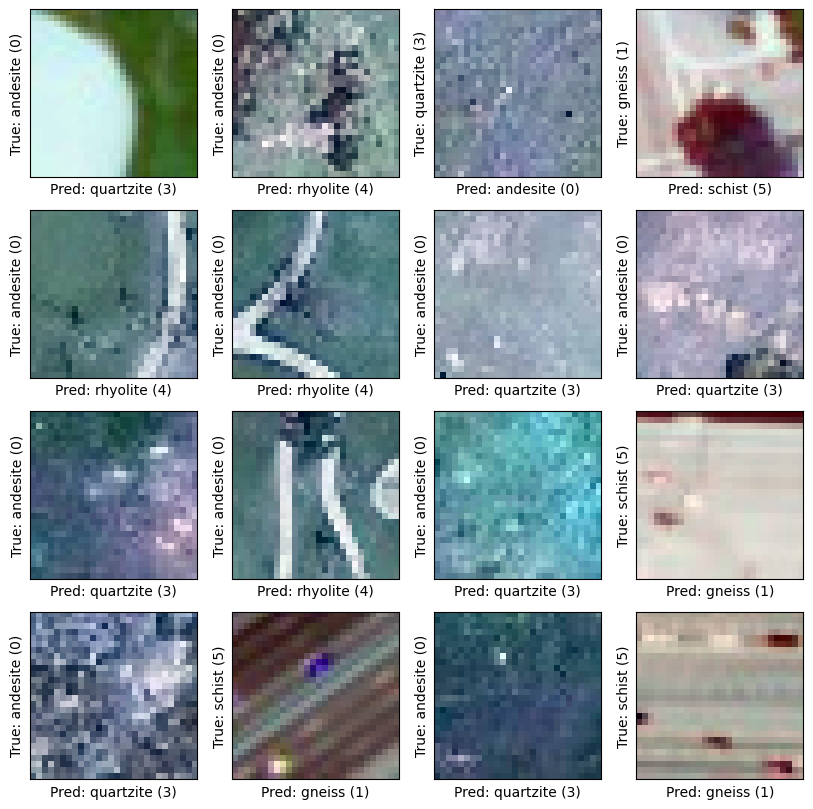

In [133]:
# plot side by side the image it predicts wrong and the true image

wrong_idx = np.where(y_pred != y_true)[0]
print(wrong_idx)
print(len(wrong_idx))
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = wrong_idx[i]

    img = test_dataset[idx][0]
    if img.min() < 0.:
          img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img.permute(1, 2, 0))
    plt.xlabel(f"Pred: {idx_to_class[y_pred[idx]]} ({y_pred[idx]})")
    plt.ylabel(f"True: {idx_to_class[y_true[idx]]} ({y_true[idx]})")
plt.show()

In [141]:
test_dataset[1]

(tensor([[[ 1.9704,  1.1690,  1.5486,  ...,  1.6541,  1.2745,  0.1146],
          [ 2.2024,  1.4854,  1.4643,  ...,  1.5697,  0.5153, -0.5813],
          [ 2.1391,  1.4221,  1.6541,  ...,  0.8316,  0.0302, -0.1807],
          ...,
          [ 1.4643,  1.4010,  1.3167,  ...,  1.5908,  1.6119,  1.6119],
          [ 1.4221,  1.4010,  1.3588,  ...,  1.5908,  1.5697,  1.5908],
          [ 1.4221,  1.4010,  1.4221,  ...,  1.5275,  1.5275,  1.5486]],
 
         [[ 1.6108,  0.9189,  1.3538,  ...,  1.6503,  1.1166, -0.0892],
          [ 1.7096,  1.1166,  1.1957,  ...,  1.4329,  0.3259, -0.7810],
          [ 1.4329,  0.8596,  1.2352,  ...,  0.5038, -0.2868, -0.5043],
          ...,
          [ 1.3933,  1.3340,  1.2550,  ...,  1.5119,  1.5317,  1.5317],
          [ 1.2945,  1.2747,  1.2352,  ...,  1.4526,  1.4922,  1.5119],
          [ 1.2945,  1.2747,  1.2945,  ...,  1.3933,  1.4526,  1.4724]],
 
         [[ 1.5155,  0.8704,  1.2467,  ...,  1.5514,  0.9780, -0.1868],
          [ 1.6768,  1.0855,

In [391]:
import torch
import matplotlib.pyplot as plt

def saliency(model, x, class_idx=None):
    model.eval()
    x_in = x.unsqueeze(0).to(device)
    x_in.requires_grad_(True)

    logits = model(x_in)
    if class_idx is None:
        class_idx = logits.argmax(dim=1).item()

    score = logits[0, class_idx]
    grad = torch.autograd.grad(score, x_in)[0][0]          # (C,H,W)
    sal = grad.abs().max(dim=0)[0]                         # (H,W)
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)
    return sal.detach().cpu()

def plot_saliency_by_outcome(model, dataset, n_per_class=3, mode="correct"):
    assert mode in {"correct", "wrong"}

    base = dataset if hasattr(dataset, "classes") else dataset.dataset
    classes = base.classes
    num_classes = len(classes)

    picked = {c: [] for c in range(num_classes)}  # store tuples (idx, true, pred)
    N = len(dataset)

    model.eval()
    with torch.no_grad():
        for i in range(N):
            x, y = dataset[i]
            pred = model(x.unsqueeze(0).to(device)).argmax(dim=1).item()

            ok = (pred == y) if mode == "correct" else (pred != y)
            if ok and len(picked[y]) < n_per_class:
                picked[y].append((i, y, pred))

    fig, axes = plt.subplots(num_classes, n_per_class * 2,
                             figsize=(3 * n_per_class * 2, 2 * num_classes))
    fig.suptitle(f"Actual vs Overlayed Saliency Map ({mode.title()} Prediction) \n", fontweight="bold", fontsize=16)
    if num_classes == 1:
        axes = axes[None, :]

    for c in range(num_classes):
        for k in range(n_per_class):
            ax_img = axes[c, 2*k]
            ax_sal = axes[c, 2*k + 1]

            if k >= len(picked[c]):
                ax_img.axis("off"); ax_sal.axis("off")
                continue

            idx, y, pred = picked[c][k]
            x, _ = dataset[idx]

            img = x.detach().cpu()
            if img.min() < 0:
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)

            # saliency for the predicted class (what drove the model's decision)
            s = saliency(model, x, class_idx=pred)

            ax_img.imshow(img.permute(1,2,0))
            if mode == "correct":
                ax_img.set_title(f"{classes[y].title()}", fontsize=10, verticalalignment="center")
            else:
                ax_img.set_title(f"True: {classes[y]} \n Pred: {classes[pred]}", fontsize=10, verticalalignment="center")
            ax_img.axis("off")

            #---- UNCOMMENT THIS BIT IF YOU WANT TO SEE SALIENCY WITHOUT OVERLAY
            # ax_sal.imshow(s, cmap="magma", interpolation="bilinear")
            # ax_sal.set_title("Saliency (Overlay)", fontsize=10)

            ax_sal.imshow(img.permute(1, 2, 0))
            ax_sal.imshow(
                s,
                cmap="inferno",        # best perceptual colormap
                alpha=0.6,           # transparency
                interpolation="bilinear"
            )
            ax_sal.set_title("Saliency (Overlay)", fontsize=10, verticalalignment="center")
            ax_sal.axis("off")

    plt.tight_layout()
    plt.show()


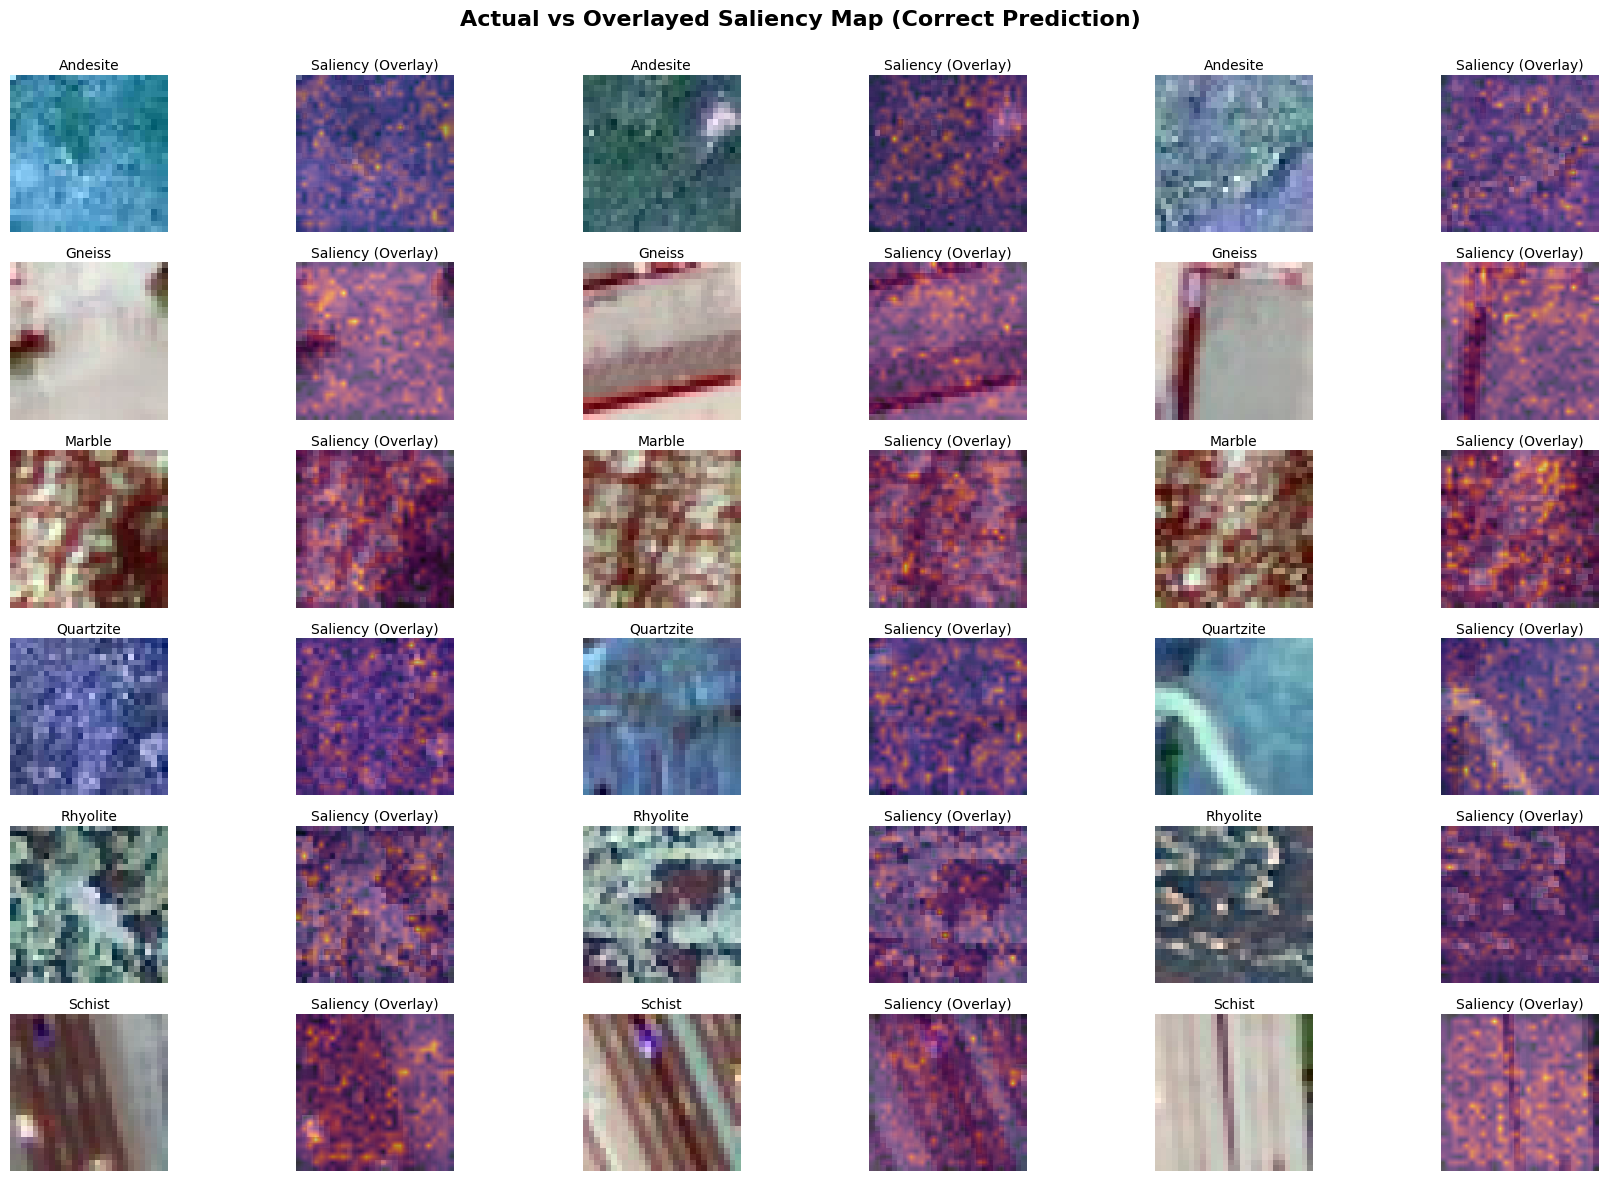

In [392]:
plot_saliency_by_outcome(
    small_cnn,
    test_dataset,
    n_per_class=3,
    mode="correct",
)

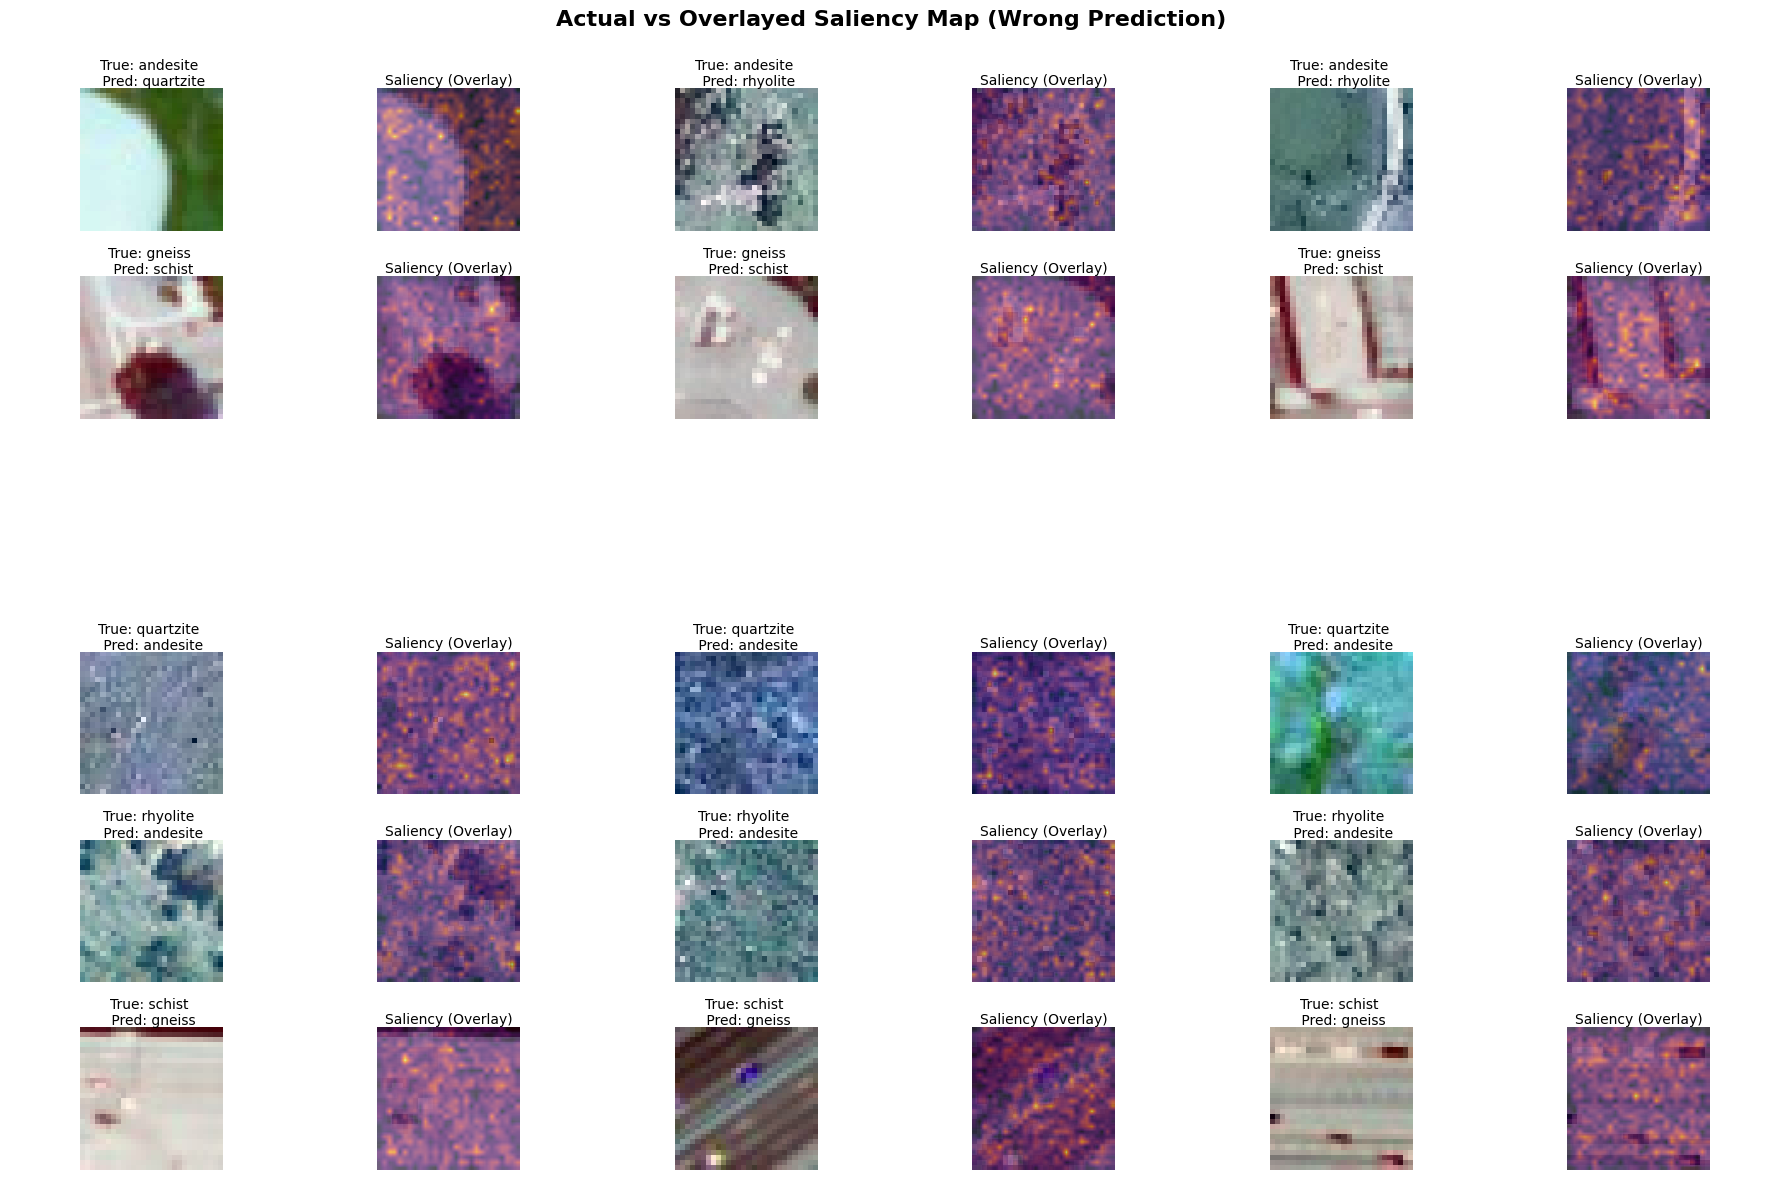

In [393]:
plot_saliency_by_outcome(small_cnn, test_dataset, n_per_class=3, mode="wrong")